In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Integer
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin


In [2]:
class BooleanConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        boolean_features = X.select_dtypes(include=['bool']).columns.tolist()
        X[boolean_features] = X[boolean_features].astype(int)
        return X

parent_folder = os.path.dirname(os.getcwd())
sibling_folder = os.path.join(parent_folder, 'data')
processed_folder = os.path.join(sibling_folder, 'processed')
icu_tabular_features = pd.read_feather(os.path.join(processed_folder, 'icu_tabular_features_0M_0ed859c799267d4ae737f8814d52726d_20240602.feather'))
icustays = pd.read_feather(os.path.join(processed_folder, 'icustays_20240602.feather'))


merged_df = pd.merge(icu_tabular_features, icustays, on=['subject_id', 'hadm_id'], how='inner') 

In [3]:

threshold = int(0.1 * len(merged_df.columns))
cleaned_df = merged_df.dropna(thresh=threshold)

#Dropping duplicates
cleaned_df = cleaned_df.loc[~cleaned_df.duplicated(keep=False)]

In [ ]:
columns_to_drop = ['subject_id','stay_id','icu_stay_id','icu_intime','is_planed', 'icu_outtime','stay_is_readmission', 'hours_until_readmission', 'hours_to_readmission', 'neoplasie', 'aids', 'metastatic_cancer']
features = cleaned_df.drop(columns=columns_to_drop)

for col in features.select_dtypes(include=['datetime64']):
    features[col] = features[col].astype(np.int64)

features = features.ffill().bfill()

In [5]:
X = features.drop(columns=["will_be_readmitted"])
y = features["will_be_readmitted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
boolean_features = X.select_dtypes(include=['bool']).columns.tolist()
categorical_features = ['first_careunit']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('bool', BooleanConverter(), boolean_features),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

lgb_model = lgb.LGBMClassifier(random_state=42)

smote = SMOTE(random_state=42)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', lgb_model)
])


In [7]:
#Hyperparameter tuning using Genetic Algorithm
param_grid = {
    'smote__k_neighbors': Integer(1, 10),
    'classifier__num_leaves': Integer(30, 50),
    'classifier__learning_rate': Continuous(0.01, 0.1, distribution='uniform'),
    'classifier__n_estimators': Integer(50, 150),
    'classifier__min_child_samples': Integer(20, 40),
    'classifier__reg_alpha': Continuous(0.0, 0.5, distribution='uniform'),
    'classifier__reg_lambda': Continuous(0.0, 0.5, distribution='uniform')
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ga_search = GASearchCV(
    estimator=pipeline,
    cv=cv,
    scoring='roc_auc',
    param_grid=param_grid,
    population_size=50,
    generations=10,
    tournament_size=3,
    elitism=True,
    crossover_probability=0.8,
    mutation_probability=0.1,
    criteria='max',
    algorithm='eaMuPlusLambda',
    n_jobs=-1,
    verbose=True,
    keep_top_k=2
)


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

ga_search.fit(X_train, y_train)
best_clf = ga_search.best_estimator_

y_train_pred = best_clf.predict(X_train)
y_train_pred_proba = best_clf.predict_proba(X_train)[:, 1]
y_test_pred = best_clf.predict(X_test)
y_test_pred_proba = best_clf.predict_proba(X_test)[:, 1]

accuracy_train = accuracy_score(y_train, y_train_pred)
auroc_train = roc_auc_score(y_train, y_train_pred_proba)
accuracy_test = accuracy_score(y_test, y_test_pred)
auroc_test = roc_auc_score(y_test, y_test_pred_proba)

cross_val_scores = cross_val_score(best_clf, X_train, y_train, cv=cv, scoring='roc_auc')



In [9]:
print("Train Accuracy:", accuracy_train)
print("Train AUROC:", auroc_train)
print("Test Accuracy:", accuracy_test)
print("Test AUROC:", auroc_test)
print("Cross-Validation Scores:", cross_val_scores)
print("Mean Cross-Validation Score:", np.mean(cross_val_scores))

Train Accuracy: 0.8515625
Train AUROC: 0.9171768707482993
Test Accuracy: 0.7272727272727273
Test AUROC: 0.7739130434782608
Cross-Validation Scores: [0.65       0.8        0.74583333 0.77192982 0.62280702]
Mean Cross-Validation Score: 0.7181140350877193


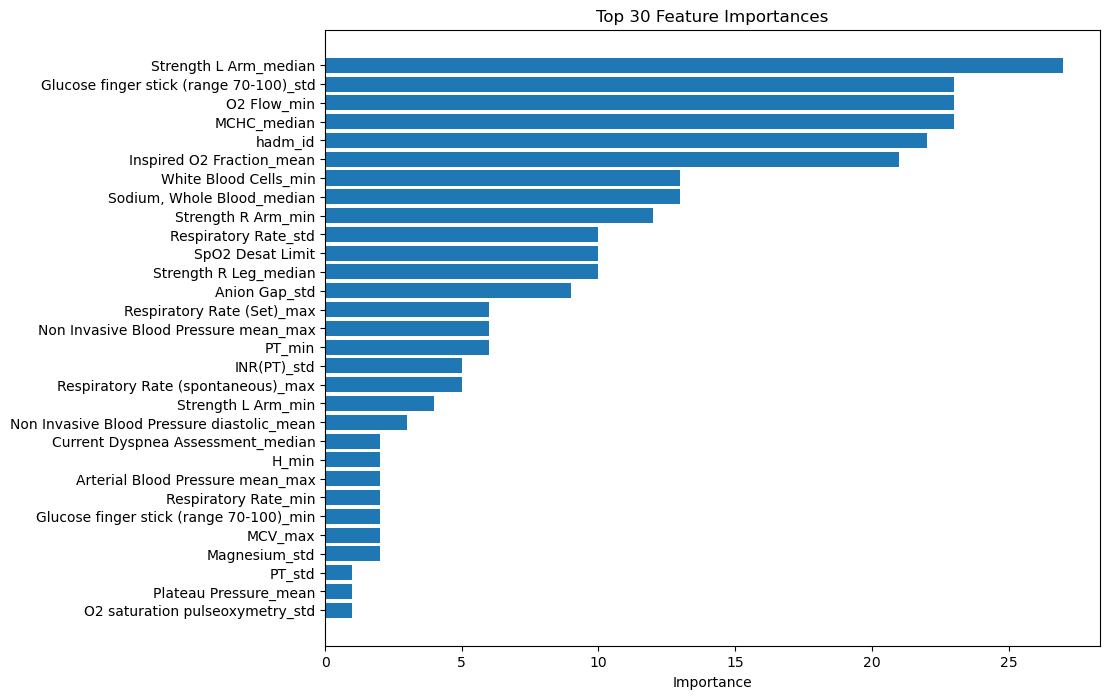

In [11]:
# Extract feature names after preprocessing
preprocessor.fit(X)
feature_names = (
    preprocessor.named_transformers_['bool'].transform(X).columns.tolist() + 
    preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numeric_features).tolist() +
    preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
)


plt.figure(figsize=(10, 8))
importance = best_clf.named_steps['classifier'].feature_importances_
indices = np.argsort(importance)[-30:]

plt.barh(range(len(indices)), importance[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.show()

In [ ]:
#ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



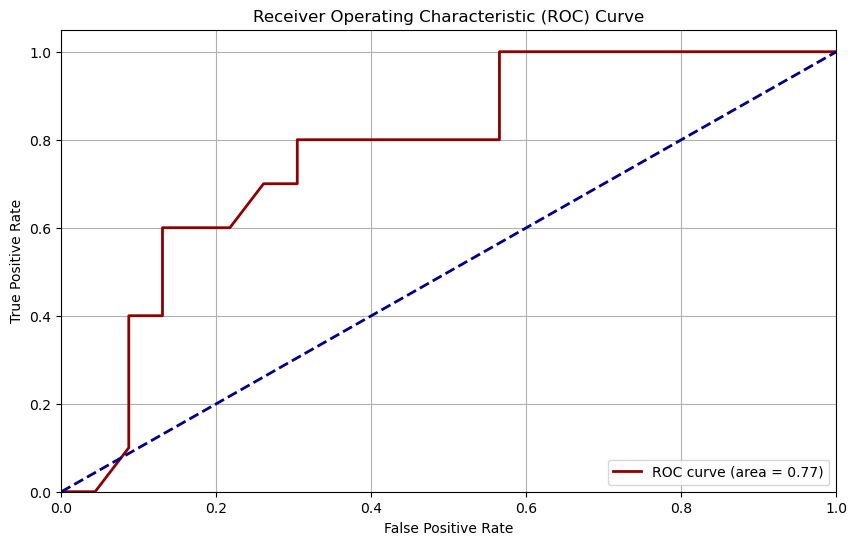

In [19]:
plot_roc_curve(y_test, y_test_pred_proba)